In [1]:
import logging
import torch
import data
import os
import numpy as np

from models import imagebind_model
from models.imagebind_model import ModalityType, load_module
from models import lora as LoRA

from models.pc_ae_net import PointcloudAutoencoder
from utils.latent_ops import slerp

from datasets.shapetalk import ShapeTalkDataset

logging.basicConfig(level=logging.INFO, force=True)

lora = False
linear_probing = False
device = "cuda:2"  # "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(device)
load_head_post_proc_finetuned = True

decoder_path = '/root/volume/.checkpoints/decoder/changeit3m-epoch=347-val_loss=0.00.ckpt/checkpoint/mp_rank_00_model_states.pt'

top_img_dir = 'images/full_size/'
shapetalk_file = 'language/shapetalk_raw_public_version_0.csv'
top_shape_dir = 'point_clouds/scaled_to_align_rendering/'

/root/anaconda3/envs/imagebind_LoRA/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/anaconda3/envs/imagebind_LoRA/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/root/anaconda3/envs/imagebind_LoRA/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


In [2]:

# breakpoint()
model = imagebind_model.imagebind_huge(pretrained=True, device=device, model_path="/root/volume/.checkpoints/deepspeed_3d_text_full_1024_v1/imagebind-epoch=57-val_loss=1.37.ckpt/checkpoint/mp_rank_00_model_states.pt", deepspeed=True)

model.eval()
model.to(device)

ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (shape): Point3DPreprocessor(
      (cls_token): tensor((1, 1, 384), requires_grad=True)
      (cls_pos): tensor((1, 1, 384), requires_grad=True)
      (dvae): tensor((128,), requires_grad=False)
      (dvae): tensor((128,), requires_grad=False)
      (dvae): tensor((), requires_grad

In [244]:
# get shapes from cls
ds = ShapeTalkDataset('/root/volume/datasets/shapetalk/', pair_type='edit', split='train')


In [245]:
# Text prompting
idx = 6
shape, path, text, context, target, target_img, img_path = ds[idx]

print(shape.shape, text.shape)
inputs = {
    ModalityType.SHAPE: shape.unsqueeze(0).to(device),
    ModalityType.TEXT: text.to(device),
}

torch.Size([1024, 3]) torch.Size([1, 77])


In [236]:
# Image prompting
idx = 92
shape, path, text, context, target, target_img, img_path = ds[idx]

print(shape.shape, text.shape)
inputs = {
    ModalityType.SHAPE: shape.unsqueeze(0).to(device),
    ModalityType.VISION: target_img.unsqueeze(0).to(device),
}

torch.Size([1024, 3]) torch.Size([1, 77])


In [246]:

with torch.no_grad():
    embeddings = model(inputs)

e0 = embeddings['shape']
e1 = embeddings['text']
# e1 = embeddings['vision']
e1 = torch.nn.functional.normalize(e1)
print(e0.shape)

checkpoint = torch.load(decoder_path, map_location=device)
decoder = PointcloudAutoencoder(1024)
# deepspeed.DeepSpeedEngine.load_checkpoint(load_dir=model_path, load_module_only=True)
checkpoint_state_dict = checkpoint['module']

# Then modify the keys
new_state_dict = {key.replace('_forward_module.ae_model.', ''): value for key, value in checkpoint_state_dict.items()}
decoder.load_state_dict(new_state_dict, strict=True)
decoder.to(device)

inter_l = [slerp(e0, e1, t) for t in np.arange(0.1, 1., 0.2)]
inter_l = torch.cat(inter_l, dim=0)

embeddings = torch.cat([e0, e1, inter_l], dim=0)

points = decoder(embeddings)


torch.Size([1, 1024])


Shape of the Point Cloud: torch.Size([7, 4096, 3]) torch.Size([1024, 3])
This is a display. frame is thinner monitor is longer stand is round
/root/volume/datasets/shapetalk/point_clouds/scaled_to_align_rendering/display/ShapeNet/f6a08ec163a037c310b3ff08c68acccf.npz


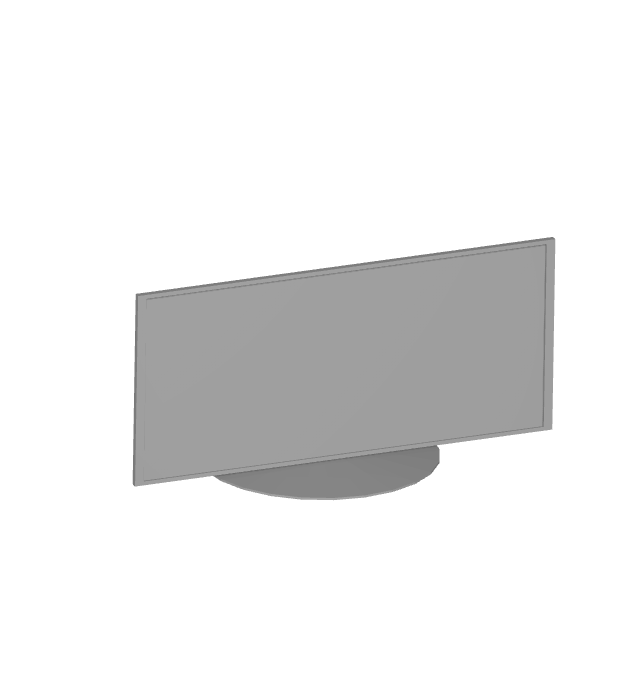

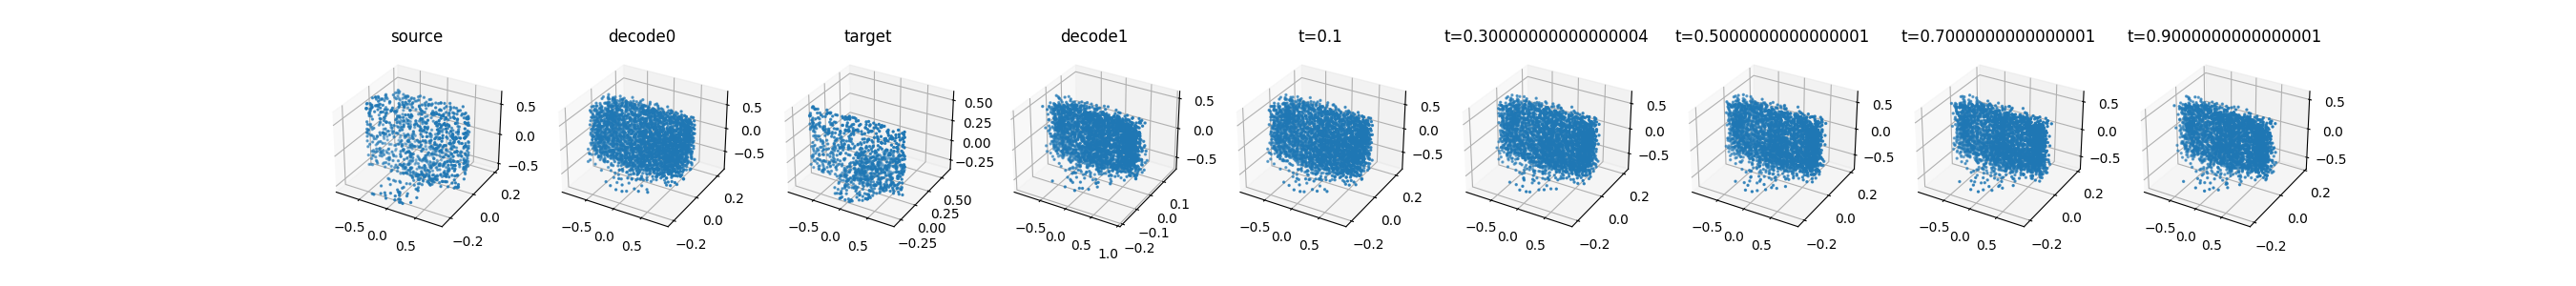

In [247]:
from utils.simple_vis import visualize_point_clouds_3d_v2
from PIL import Image

print('Shape of the Point Cloud:', points.shape, shape.shape)
print(context)
print(path)


points = points.numpy(force=True)
shape = shape.numpy(force=True)

Image.open(img_path).show()

visualize_point_clouds_3d_v2([shape, points[0], target, *points[1:]], 
                                title_lst= ['source', 'decode0', 'target', 'decode1', *[f't={t}' for t in np.arange(0.1, 1., 0.2)]], 
                                vis_axis_order=[0, 2, 1]).show()

In [248]:
shape = data.load_and_transform_3D([path], sample_points_num=2048).squeeze(0)

In [249]:
save_xml(f'scene/scene-{idx}-target-gt.xml', target)
save_xml(f'scene/scene-{idx}-source-gt.xml', shape)
save_xml(f'scene/scene-{idx}-0.xml', points[0])
save_xml(f'scene/scene-{idx}-10.xml', points[1])
for i in range(5):
    save_xml(f'scene/scene-{idx}-{i*2+1}.xml', points[i+2])

(1024, 3)
torch.Size([2048, 3])
(4096, 3)
(4096, 3)
(4096, 3)
(4096, 3)
(4096, 3)
(4096, 3)
(4096, 3)


In [235]:

def save_xml(file_name, pointcloud):
    def standardize_bbox(pcl, points_per_object):
        pt_indices = np.random.choice(pcl.shape[0], points_per_object, replace=False)
        np.random.shuffle(pt_indices)
        pcl = pcl[pt_indices] # n by 3
        mins = np.amin(pcl, axis=0)
        maxs = np.amax(pcl, axis=0)
        center = ( mins + maxs ) / 2.
        scale = np.amax(maxs-mins)
        print("Center: {}, Scale: {}".format(center, scale))
        result = ((pcl - center)/scale).astype(np.float32) # [-0.5, 0.5]
        return result

    xml_head = \
    """
    <scene version="0.6.0">
        <integrator type="path">
            <integer name="maxDepth" value="-1"/>
        </integrator>
        <sensor type="perspective">
            <float name="farClip" value="100"/>
            <float name="nearClip" value="0.1"/>
            <transform name="toWorld">
                <lookat origin="4,4,1.5" target="0,0,0" up="0,0,1"/>
            </transform>
            <float name="fov" value="25"/>
            
            <sampler type="ldsampler">
                <integer name="sampleCount" value="256"/>
            </sampler>
            <film type="hdrfilm">
                <integer name="width" value="1600"/>
                <integer name="height" value="1600"/>
                <rfilter type="gaussian"/>
            </film>
        </sensor>
        
        <bsdf type="roughplastic" id="surfaceMaterial">
            <string name="distribution" value="ggx"/>
            <float name="alpha" value="0.05"/>
            <float name="intIOR" value="1.46"/>
            <rgb name="diffuseReflectance" value="1,1,1"/> <!-- default 0.5 -->
        </bsdf>
        
    """

    xml_ball_segment = \
    """
        <shape type="sphere">
            <float name="radius" value="0.025"/>
            <transform name="toWorld">
                <translate x="{}" y="{}" z="{}"/>
            </transform>
            <bsdf type="diffuse">
                <rgb name="reflectance" value="{},{},{}"/>
            </bsdf>
        </shape>
    """

    xml_tail = \
    """
        <shape type="rectangle">
            <ref name="bsdf" id="surfaceMaterial"/>
            <transform name="toWorld">
                <scale x="10" y="10" z="1"/>
                <translate x="0" y="0" z="-1"/>
            </transform>
        </shape>
        <shape type="cube">
            <ref name="wall1" id="surfaceMaterial"/>
            <transform name="toWorld">
                <scale x="10" y="1" z="10"/>
                <translate x="0" y="-10" z="0"/>
            </transform>
        </shape>
        <shape type="cube">
            <ref name="wall2" id="surfaceMaterial"/>
            <transform name="toWorld">
                <scale x="1" y="10" z="10"/>
                <translate x="-10" y="0" z="0"/>
            </transform>
        </shape>
        
        <shape type="rectangle">
            <transform name="toWorld">
                <scale x="10" y="10" z="1"/>
                <lookat origin="-4,4,20" target="0,0,0" up="0,0,1"/>
            </transform>
            <emitter type="area">
                <rgb name="radiance" value="6,6,6"/>
            </emitter>
        </shape>
    </scene>
    """

    def colormap(x,y,z):
        vec = np.array([x,y,z])
        vec = np.clip(vec, 0.001,1.0)
        norm = np.sqrt(np.sum(vec**2))
        vec /= norm
        return [vec[0], vec[1], vec[2]]
    xml_segments = [xml_head]

    pcl = pointcloud
    print(pcl.shape)
    pcl = pcl[:,[2,0,1]]
    # pcl *= 0.8
    pcl[:,0] *= -1
    pcl[:,2] += 0.0125

    for i in range(pcl.shape[0]):
        color = colormap(pcl[i,0]+0.5,pcl[i,1]+0.5,pcl[i,2]+0.5-0.0125)
        xml_segments.append(xml_ball_segment.format(pcl[i,0],pcl[i,1],pcl[i,2], *color))
    xml_segments.append(xml_tail)

    xml_content = str.join('', xml_segments)

    with open(file_name, 'w') as f:
        f.write(xml_content)